# Mesterséges neurális hálók tanítása tensorflow-val

A mai gyakorlaton egy két rejtett réteges neuronháló tanítunk kézzel írt számok felismerésére.

## Neuronháló

![Neuronháló](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png)

## MNIST adatbázis

![MNIST adatbázis](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

Az adatbázis kézzel írt számokról készült képeket tartalmaz. Összesen 60000 db példa található a tanító adatbázisban és 10000 a teszt halmazban. A képeket egységes méretre hozták (28x28 pixel) és minden pixel intenzitását 0 és 1 közé normalizáltak. A képek 1-D-s numpy tömbökben vannak tárolva.

Bővebben: http://yann.lecun.com/exdb/mnist/

Első lépésben telepítsük a matplotlib csomagot, majd improtáljuk a szükséges csomagokat és letöltjük az adatbázis a /tmp/data könyvtárba.

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


A következő lépés a tanítási paraméterek és a neuronháló strukturához a változók inicializálása.

In [0]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

A neuronháló tanításához létrehozunk egy bemeneti függvényt, ami a korábba letöltött adatbázisból ú.n. batch-eket fog készíteni.

In [0]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

A következő kód létrehozza a 2 rejtett réteges hálózatot, lineáris aktivációs függvénnyel.

In [0]:
# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

A tanításhoz szükséges dolgok beállítása:
- neuronháló kimenetének kezelése
- loss függvény megadása
- hibametrika választása

In [0]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

A fenti kódok meghívása, estimator létrehozása.

In [6]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0d6d9354d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpW1fUWr', '_save_summary_steps': 100}


### Neuronháló tanítása
Megfigyelhető, hogy minden 100. step után közöl információt és 1000 lépésig fut (ezeket feljebb állítottuk be).
Tanítás során célszerű figyelni a loss értékét, az alapján tudjuk beállítani a tanulási paramétereket.

In [7]:
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpW1fUWr/model.ckpt.
INFO:tensorflow:loss = 2.651125, step = 1
INFO:tensorflow:global_step/sec: 257.657
INFO:tensorflow:loss = 0.42789042, step = 101 (0.392 sec)
INFO:tensorflow:global_step/sec: 263.178
INFO:tensorflow:loss = 0.27790523, step = 201 (0.377 sec)
INFO:tensorflow:global_step/sec: 265.42
INFO:tensorflow:loss = 0.31373686, step = 301 (0.377 sec)
INFO:tensorflow:global_step/sec: 274.771
INFO:tensorflow:loss = 0.4330222, step = 401 (0.367 sec)
INFO:tensorflow:global_step/sec: 209.157
INFO:tensorflow:loss = 0.24066003, step = 501 (0.477 sec)
INFO:tensorflow:global_step/sec: 190.125
INFO:tensorflow:loss = 0.33721492, step = 601 (0.525 sec)
INFO:tensorflow:global_step/sec: 189.36
INFO:tensorflow:

Tanítás után kiértékelünk a teszt halmazon.
**Fontos: csak a legjobb modellünket értékeljük ki a teszt halmazon, különben peeking-elünk.**

Peeking (kukucskálás): a teszt halmazon látott teljesítmény alapján optimalizáljuk az algoritmusunk paramétereit ezért nem tudjuk hogy az milyen jól általánosít.

In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-08:54:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpW1fUWr/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-25-08:54:19
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9099, global_step = 1000, loss = 0.3034034


{'accuracy': 0.9099, 'global_step': 1000, 'loss': 0.3034034}

Kiértékelhetünk csak néhány példát is a következő módon:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpW1fUWr/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


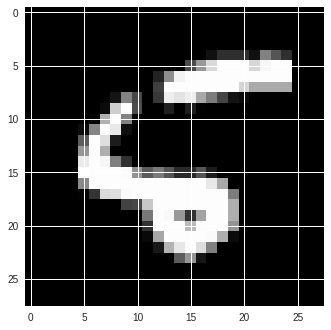

Model prediction: 6 Real: 5


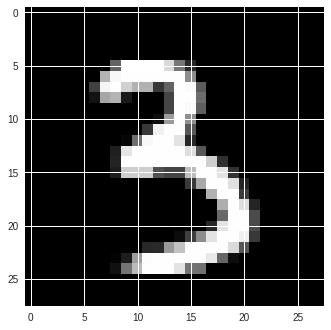

Model prediction: 5 Real: 3


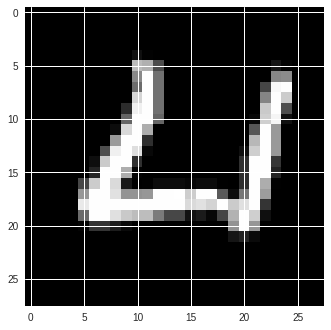

Model prediction: 6 Real: 4


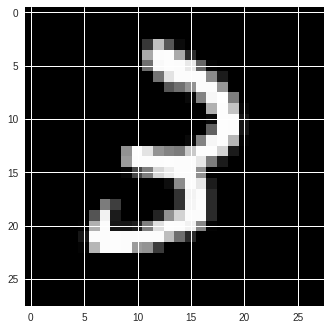

Model prediction: 2 Real: 3


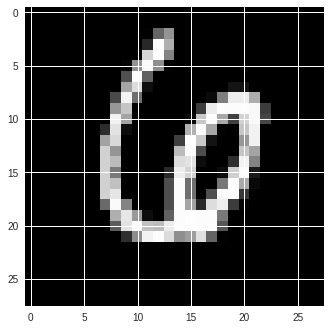

Model prediction: 7 Real: 6


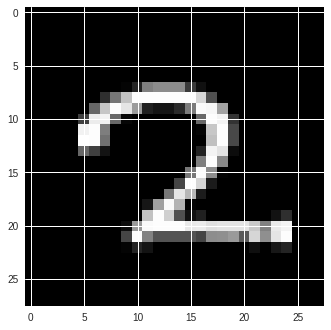

Model prediction: 7 Real: 2


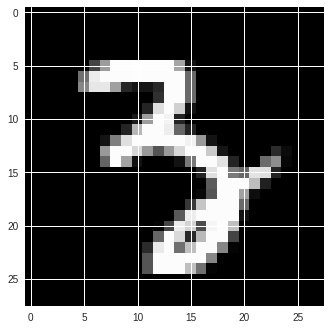

Model prediction: 5 Real: 3


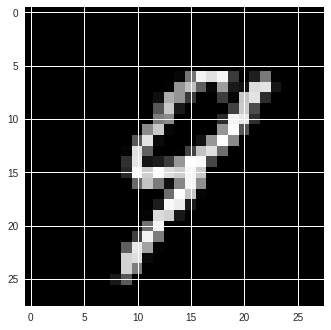

Model prediction: 4 Real: 9


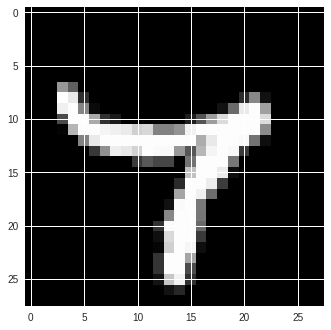

Model prediction: 4 Real: 7


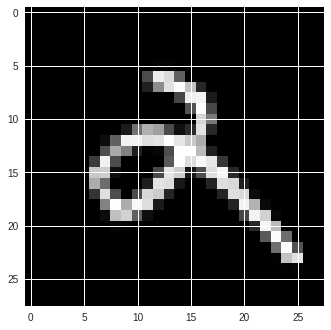

Model prediction: 9 Real: 2


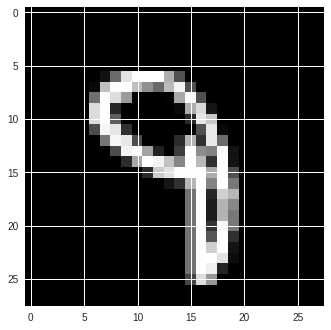

Model prediction: 4 Real: 9


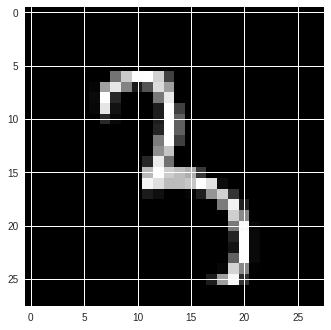

Model prediction: 5 Real: 3


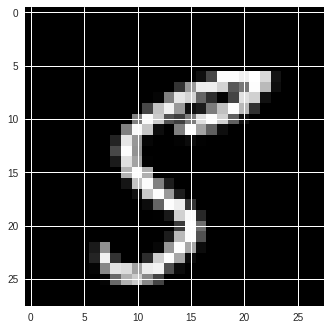

Model prediction: 7 Real: 5


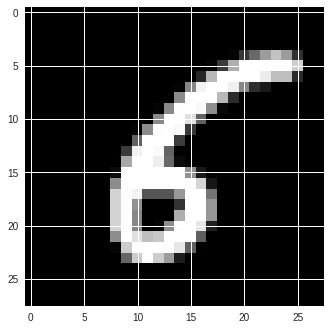

Model prediction: 5 Real: 6


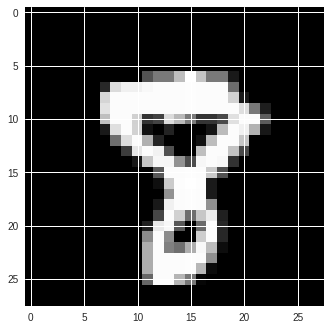

Model prediction: 7 Real: 8


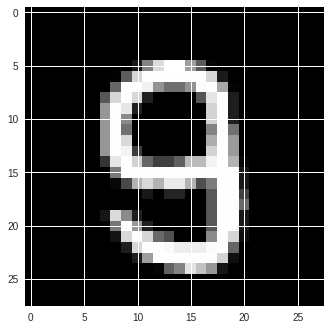

Model prediction: 8 Real: 9


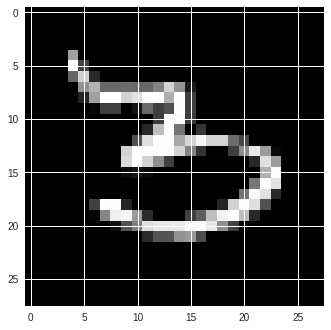

Model prediction: 5 Real: 3


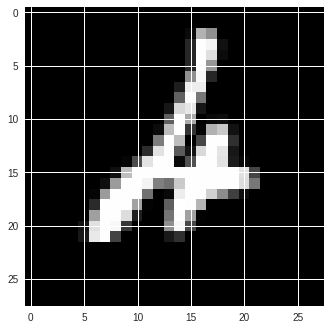

Model prediction: 6 Real: 4


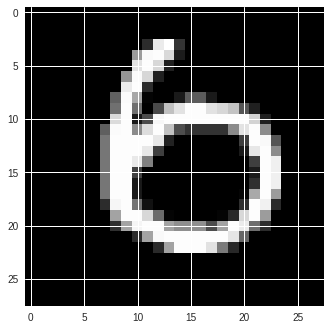

Model prediction: 0 Real: 6


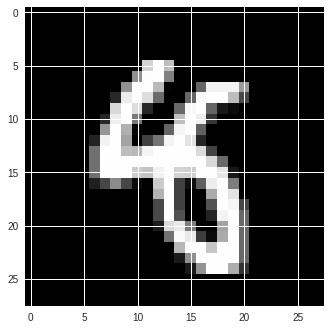

Model prediction: 4 Real: 8


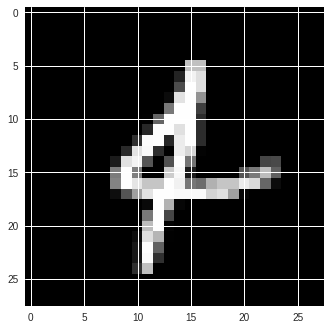

Model prediction: 6 Real: 4


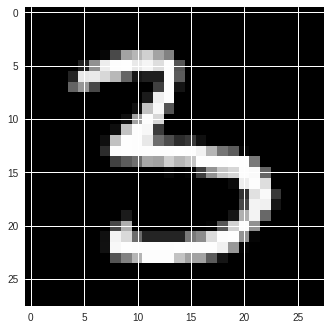

Model prediction: 5 Real: 3


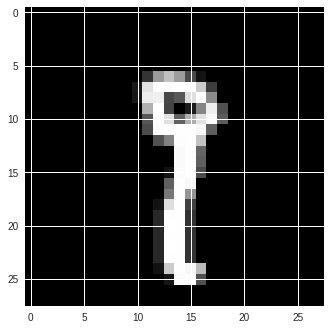

Model prediction: 7 Real: 9


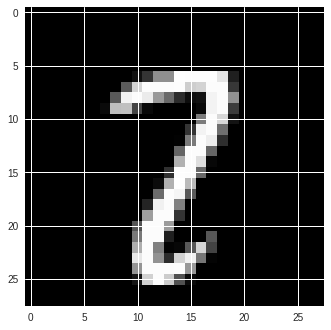

Model prediction: 7 Real: 2


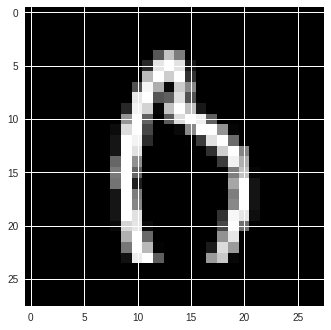

Model prediction: 9 Real: 0


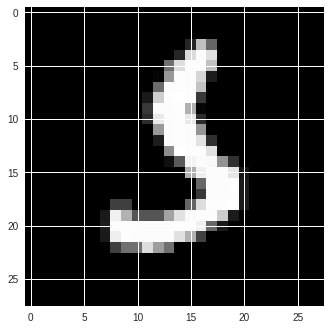

Model prediction: 3 Real: 5


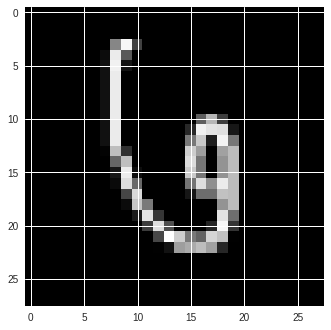

Model prediction: 4 Real: 6


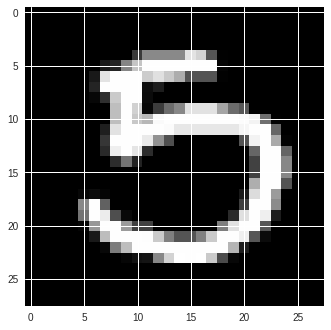

Model prediction: 0 Real: 5


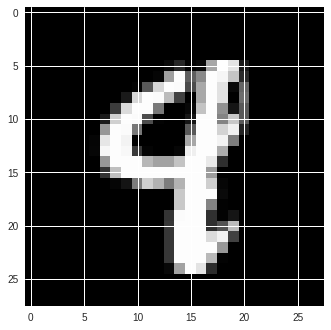

Model prediction: 4 Real: 9


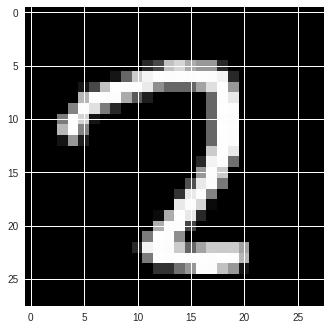

Model prediction: 7 Real: 2


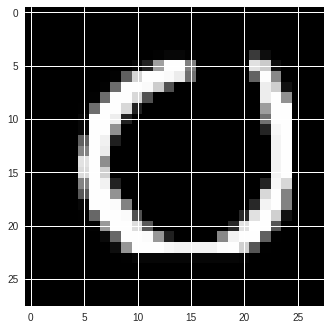

Model prediction: 5 Real: 0


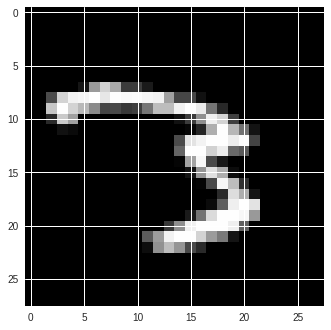

Model prediction: 7 Real: 3


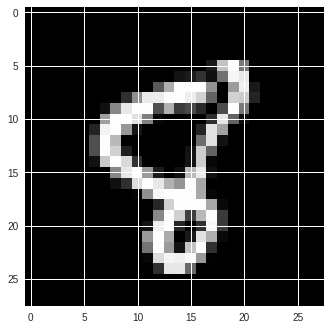

Model prediction: 9 Real: 8


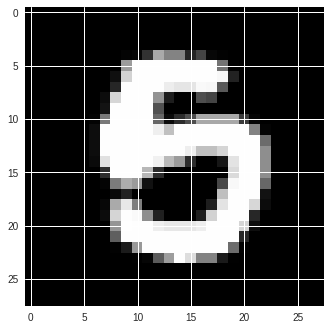

Model prediction: 8 Real: 5


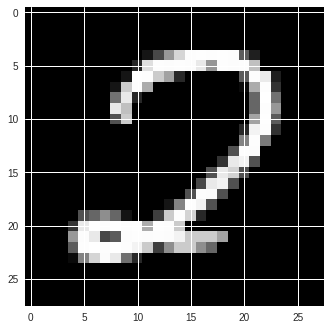

Model prediction: 5 Real: 2


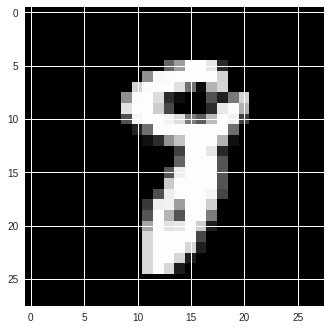

Model prediction: 7 Real: 8


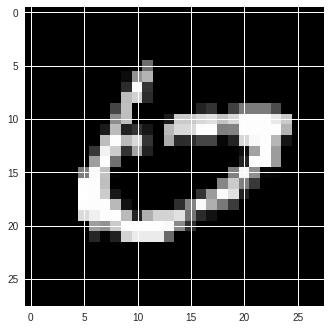

Model prediction: 0 Real: 6


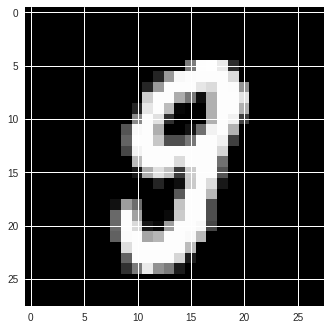

Model prediction: 8 Real: 9


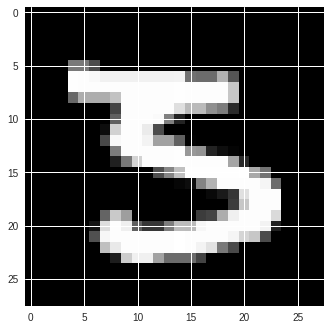

Model prediction: 5 Real: 3


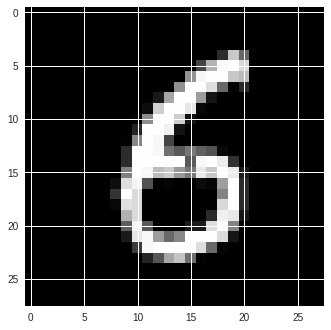

Model prediction: 5 Real: 6


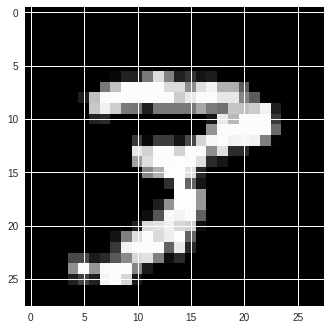

Model prediction: 7 Real: 3


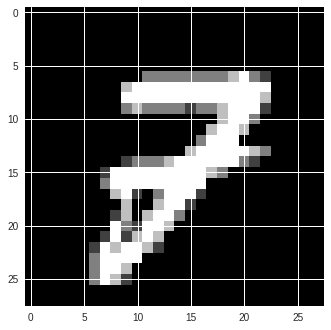

Model prediction: 9 Real: 7


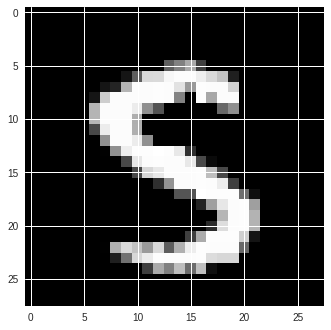

Model prediction: 8 Real: 5


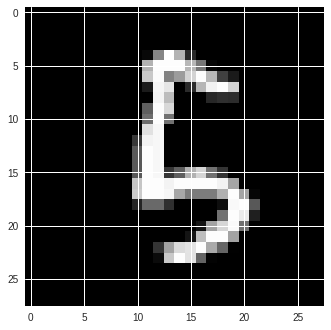

Model prediction: 8 Real: 5


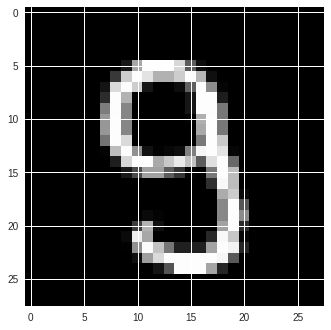

Model prediction: 8 Real: 9


In [9]:
# Predict single images
n_images = 500
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn_test_few = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn_test_few))

# Display
#for i in range(5):
#    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#    plt.show()
#    print("Model prediction:", preds[i], "Real:", mnist.test.labels[i])
    
for i in range(n_images):
    if (preds[i] != mnist.test.labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
        plt.show()
        print("Model prediction:", preds[i], "Real:", mnist.test.labels[i])

### Feladatok
1. Keressük meg, hogy mely képeken hibázott a háló!
2. Változtassuk a neuronok számát, a batch méretet és a num_step értékét!
3. Adjunk hozzá a neuronhálóhoz további rejtett rétegeket!